# ResNet & Lifting Example

In [1]:
%matplotlib inline

import os

# Packages for multithreading and loading images
from queue import Queue
import threading
from PIL import Image
import pandas as pd

# Numerical packages
import tensorflow as tf
import numpy as np
import math

# Package to restrict tensorflow to only use one gpu - see https://github.com/fbcotter/py3nvml.git
try:
    import py3nvml
    py3nvml.grab_gpus(1)
except:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''

# Plotting packages
import matplotlib.pyplot as plt

In [ ]:
try:
    from plotters import imshowNormalize, imshow, plot_axgrid
except:
    %load -r 5:66,442: https://raw.githubusercontent.com/fbcotter/plotters/master/plotters.py

In [ ]:
try:
    from tf_ops import convolution
except:
    %load -r 10:76,113:190,662:879 https://raw.githubusercontent.com/fbcotter/tf_ops/master/tf_ops.py

# Get a test image

In [4]:
from PIL import Image
import requests
from io import BytesIO

# Can use any image url, or a local image if you prefer
example_img = 'https://upload.wikimedia.org/wikipedia/commons/thumb/9/94/Trinity_College_-_Great_Court_02.jpg/640px-Trinity_College_-_Great_Court_02.jpg'
response = requests.get(example_img)
img_pil = Image.open(BytesIO(response.content))
img = np.array(img_pil).astype(np.float32)

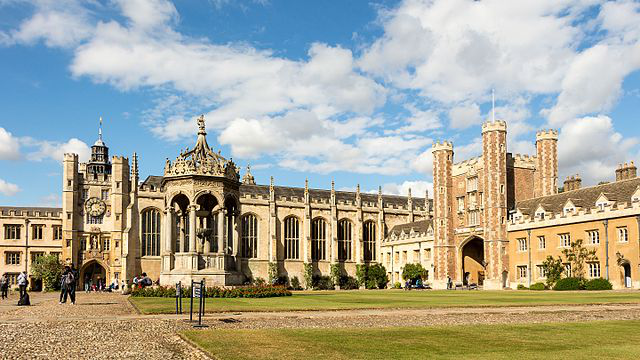

In [5]:
img_pil

# Define Neural Nets

## Some convenience functions

In [6]:
def residual_core(x, out_dim, stride):
    """Define the core mapping of a res layer, i.e. F(x)
    """
    x = tf.nn.relu(x)
    x = convolution(x, out_dim, size=3, stride=stride, name='sub1')
    x = tf.nn.relu(x)
    x = convolution(x, out_dim, size=3, stride=stride, name='sub2')
    
    return x

In [7]:
def residual(x, out_dim, stride):
    """Define the full residual layer, i.e. x + F(x)
    """
    orig_x = x
    x = residual_core(x, out_dim, stride)
    x += orig_x
    return x

In [8]:
def lift_residual(x_even, x_odd, out_dim, stride):
    """Define a Lifting Layer
    
    The P and the U blocks for this lifting layer are non-linear functions. 
    These are the same form as the F(x) in a residual layer (i.e. two
    convolutions)
    """
    with tf.variable_scope('P'):
        # Calculate d = x_e - Px_o
        d = x_even - residual_core(x_odd, out_dim, stride)
    
    with tf.variable_scope('U'):
        # Calculate s = x_o + Ud
        s = x_odd + residual_core(d, out_dim, stride)
    
    return d, s

In [9]:
def lift_residual_inv(d, s, out_dim, stride):
    """Define the inverse of a lifting layer
    
    Share the variables with the forward lifting.
    """
    with tf.variable_scope('U') as scope:
        # Calculate x_o = s - Ud
        scope.reuse_variables()        
        x_o = s - residual_core(d, out_dim, stride)
    
    with tf.variable_scope('P') as scope:
        # Calculate x_e = d + Px_o
        scope.reuse_variables() 
        x_e = d + residual_core(x_o, out_dim, stride)
        
    return x_e, x_o    

# Standard CNN - no feed through layers

In [10]:
tf.reset_default_graph()
x_in = tf.placeholder(tf.float32, [None, *img.shape])
# Forward pass
with tf.variable_scope('layer1'):
    l1 = residual_core(x_in, 3, 1)

with tf.variable_scope('layer2'):
    l2 = residual_core(l1, 3, 1)

with tf.variable_scope('layer3'):
    l3 = residual_core(l2, 3, 1)
    

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
l1_n, l2_n, l3_n = sess.run([l1, l2, l3], {x_in : [img]})

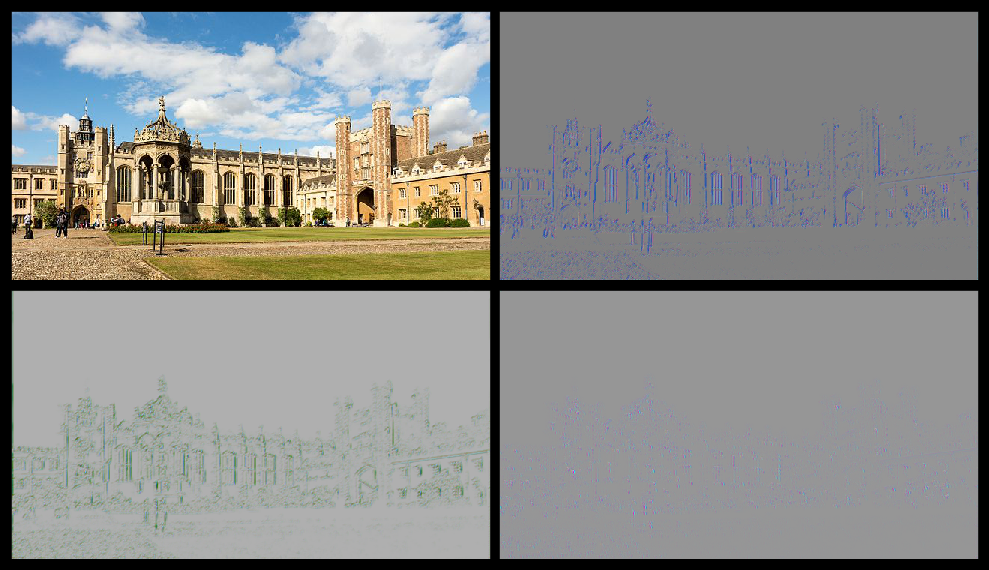

In [13]:
fig, ax = plot_axgrid(2, 2, figsize=(14,8))
ax[0,0].imshow(imshowNormalize(img))
ax[0,1].imshow(imshowNormalize(l1_n[0]))
ax[1,0].imshow(imshowNormalize(l2_n[0]))
ax[1,1].imshow(imshowNormalize(l3_n[0]))

# Now compare to a residual Net

In [15]:
tf.reset_default_graph()
x_even = tf.placeholder(tf.float32, [None, *img.shape])
x_odd = tf.placeholder(tf.float32, [None, *img.shape])

# Forward pass
with tf.variable_scope('layer1'):
    d1, s1 = lift_residual(x_even, x_odd, 3, 1)

with tf.variable_scope('layer2'):
    d2, s2 = lift_residual(d1, s1, 3, 1)

with tf.variable_scope('layer3'):
    d3, s3 = lift_residual(d2, s2, 3, 1)
    d2_hat, s2_hat = lift_residual_inv(d3, s3, 3, 1)

with tf.variable_scope('layer2'):
    d1_hat, s1_hat = lift_residual_inv(d2_hat, s2_hat, 3, 1)
    
with tf.variable_scope('layer1'):
    x_even_hat, x_odd_hat = lift_residual_inv(d1_hat, s1_hat, 3, 1)

In [16]:
# Note that we feed in x to both the 'even' and 'odd' inputs, rather than splitting 
sess = tf.Session()
sess.run(tf.global_variables_initializer())
d1_n, s1_n, d2_n, s2_n, d3_n, s3_n, x_even_hat_n, x_odd_hat_n = sess.run(
    [d1, s1, d2, s3, d3, s3, x_even_hat, x_odd_hat], 
    {x_even: [img], x_odd:[img]})

Plot the 's' and 'd' images at each layer of the lattice

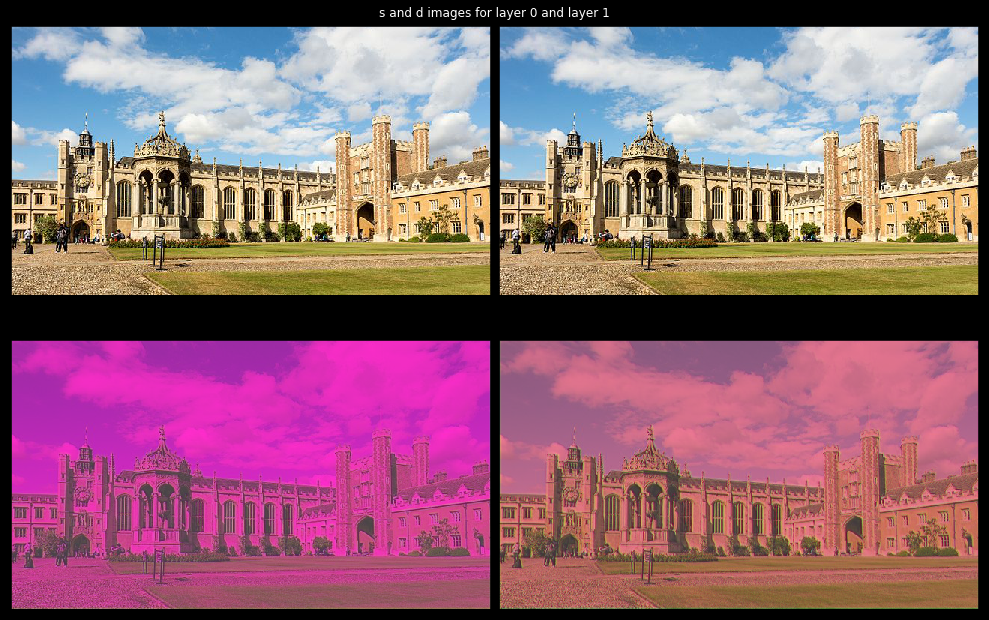

In [22]:
fig, ax = plot_axgrid(2, 2, figsize=(14,9))
fig.suptitle('s and d images for layer 0 and layer 1', color='w')
ax[0,0].imshow(imshowNormalize(img))
ax[0,1].imshow(imshowNormalize(img))
ax[1,0].imshow(imshowNormalize(d1_n[0]))
ax[1,1].imshow(imshowNormalize(s1_n[0]))

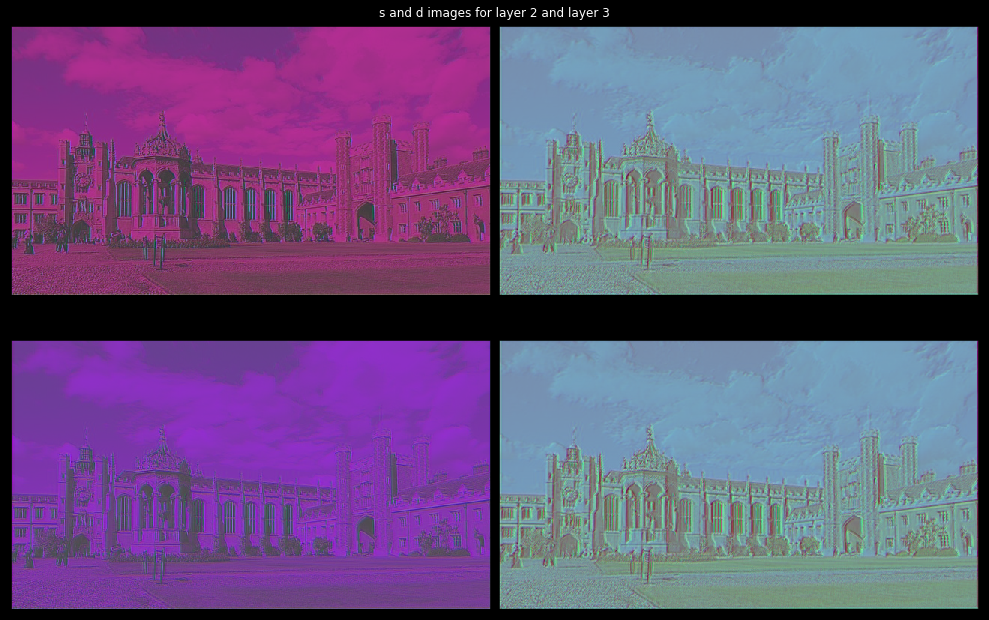

In [24]:
fig, ax = plot_axgrid(2, 2, figsize=(14,9))
fig.suptitle('s and d images for layer 2 and layer 3', color='w')
ax[0,0].imshow(imshowNormalize(d2_n[0]))
ax[0,1].imshow(imshowNormalize(s2_n[0]))
ax[1,0].imshow(imshowNormalize(d3_n[0]))
ax[1,1].imshow(imshowNormalize(s3_n[0]))

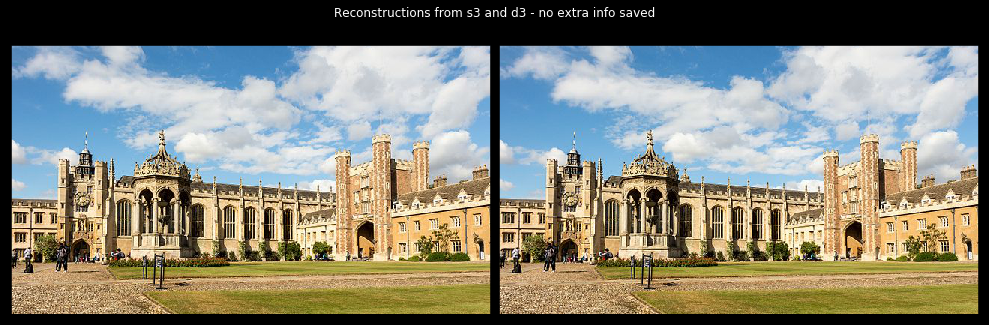

In [29]:
fig, ax = plot_axgrid(1, 2, figsize=(14,5))
fig.suptitle('Reconstructions from s3 and d3 - no extra info saved', color='w')
ax[0].imshow(imshowNormalize(x_even_hat_n[0]))
ax[1].imshow(imshowNormalize(x_odd_hat_n[0]))